In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_folder = 'DB1/train'
test_folder = 'DB1/test'
num_Class = 30
num_Sample = 21
train_data, train_label = [], []
test_data, test_label = [], []
for c in range(num_Class):
    for s in range(1, 1+num_Sample):
        img_path = os.path.join(train_folder, '{:02d}_{:02d}.png'.format(c+1, s))
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        train_data.append(img.reshape((-1, 1)))
        train_label.append(c)

for c in range(num_Class):
    for s in range(1, 1+num_Sample):
        img_path = os.path.join(test_folder, '{:02d}_{:02d}.png'.format(c+1, s))
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        test_data.append(img.reshape((-1, 1)))
        test_label.append(c)

In [3]:
train_vec = np.hstack(train_data)
train_vec = train_vec / np.linalg.norm(train_vec, axis=0, keepdims=True)
train_label = np.array(train_label)
test_vec = np.hstack(test_data)
test_vec = test_vec / np.linalg.norm(test_vec, axis=0, keepdims=True)
test_label = np.array(test_label)

In [4]:
mean_train = np.mean(train_vec, axis=1, keepdims=True)
std_train = np.std(train_vec - mean_train, axis=1, keepdims=True)
norm_train = (train_vec - mean_train) #/ std_train
norm_test = (test_vec - mean_train) #/ std_train

In [5]:
def PCA(X):
    C = np.dot(X.T, X)
    lamda, u = np.linalg.eig(C)
    w = np.dot(X, u)
    sw = np.sqrt(np.sum(w**2, axis=0, keepdims = True))
    norm_w = w / sw
    return norm_w


def LDA(X, meanImg, meanImgClass, num_Sample):
    M = meanImgClass - meanImg
    eigvalues, eigenvectors = np.linalg.eig(np.dot(M.T, M))
    evidx = eigvalues.argsort()[::-1][:len(eigvalues)]
    u = eigenvectors[:, evidx]
    Y = np.dot(M, u)
    Db_sqrt = np.diag(np.power(eigvalues[evidx], -0.5))
    Z = np.dot(Y, Db_sqrt)
    
    Xw = X - np.repeat(meanImgClass, num_Sample, 1)
    ZSwZ = np.dot(np.dot(Z.T, Xw), np.dot(Z.T, Xw).T)
    Uev, U = np.linalg.eig(ZSwZ)
    U_hat = U[:, Uev.argsort()]
    Wk = np.dot(Z, U_hat)
    return Wk


def NN(train, test, train_label):
    ntest = np.sum(test**2, axis=1).reshape((-1, 1))
    ntrain = np.sum(train**2, axis=1).reshape((1, -1))
    tt = np.dot(test, train.T)
    edistance = np.sqrt(ntest - 2 * tt + ntrain)
    idx = edistance.argmin(axis=1)
    prediction = train_label[idx]
    acc = np.sum(prediction==test_label) / ntest.shape[0]
    return prediction

In [6]:
acc_pca = []
W = PCA(norm_train)
for p in range(1, 21):
    ev = W[:, :p]
    pca_train = np.dot(ev.T, norm_train)
    pca_test = np.dot(ev.T, norm_test) 
    prediction = NN(pca_train.T, pca_test.T, train_label)
    acc = np.sum(prediction==test_label) / test_label.shape[0]
    acc_pca.append(acc)
    print("subspace dimensionality: {}, accuracy: {:.3f}%)".format(p, acc*100))

subspace dimensionality: 1, accuracy: 26.984%)
subspace dimensionality: 2, accuracy: 78.254%)
subspace dimensionality: 3, accuracy: 93.968%)
subspace dimensionality: 4, accuracy: 96.667%)
subspace dimensionality: 5, accuracy: 98.730%)
subspace dimensionality: 6, accuracy: 98.571%)
subspace dimensionality: 7, accuracy: 99.048%)
subspace dimensionality: 8, accuracy: 99.524%)
subspace dimensionality: 9, accuracy: 99.683%)
subspace dimensionality: 10, accuracy: 99.841%)
subspace dimensionality: 11, accuracy: 99.841%)
subspace dimensionality: 12, accuracy: 99.841%)
subspace dimensionality: 13, accuracy: 100.000%)
subspace dimensionality: 14, accuracy: 100.000%)
subspace dimensionality: 15, accuracy: 100.000%)
subspace dimensionality: 16, accuracy: 100.000%)
subspace dimensionality: 17, accuracy: 100.000%)
subspace dimensionality: 18, accuracy: 100.000%)
subspace dimensionality: 19, accuracy: 100.000%)
subspace dimensionality: 20, accuracy: 100.000%)


In [7]:
class_mean = np.zeros((train_vec.shape[0], num_Class))
for i in range(num_Class):
    idx1 = num_Sample * i
    idx2 = idx1 + num_Sample
    class_mean[:,i] = np.mean(train_vec[:,idx1:idx2], 1)

W = LDA(train_vec, mean_train, class_mean, num_Sample)
acc_LDA = []
for p in range(1, 21):
    Wp = W[:, :p]
    lda_train = np.dot(Wp.T, norm_train)
    lda_test = np.dot(Wp.T, norm_test)

    prediction = NN(lda_train.T, lda_test.T, train_label)
    acc = np.sum(prediction==test_label) / test_label.shape[0]
    acc_LDA.append(acc)
    print("subspace dimensionality: {}, accuracy: {:.3f}%)".format(p, acc*100))

subspace dimensionality: 1, accuracy: 14.127%)
subspace dimensionality: 2, accuracy: 28.571%)
subspace dimensionality: 3, accuracy: 75.556%)
subspace dimensionality: 4, accuracy: 95.079%)
subspace dimensionality: 5, accuracy: 98.095%)
subspace dimensionality: 6, accuracy: 99.683%)
subspace dimensionality: 7, accuracy: 100.000%)
subspace dimensionality: 8, accuracy: 99.683%)
subspace dimensionality: 9, accuracy: 100.000%)
subspace dimensionality: 10, accuracy: 100.000%)
subspace dimensionality: 11, accuracy: 100.000%)
subspace dimensionality: 12, accuracy: 100.000%)
subspace dimensionality: 13, accuracy: 100.000%)
subspace dimensionality: 14, accuracy: 100.000%)
subspace dimensionality: 15, accuracy: 100.000%)
subspace dimensionality: 16, accuracy: 100.000%)
subspace dimensionality: 17, accuracy: 100.000%)
subspace dimensionality: 18, accuracy: 100.000%)
subspace dimensionality: 19, accuracy: 100.000%)
subspace dimensionality: 20, accuracy: 100.000%)


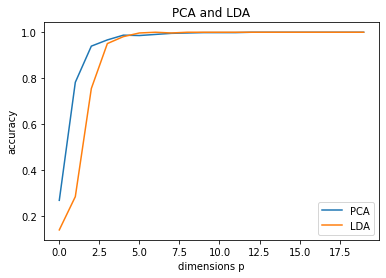

In [10]:
steps = [i for i in range(len(acc_LDA))]
plt.plot(acc_pca, label='PCA')
plt.plot(acc_LDA, label = 'LDA')
plt.xlabel('dimensions p')
plt.ylabel('accuracy')
plt.title('PCA and LDA')
plt.legend()
plt.show()